In [1]:
!pip3 install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-fswnmgch/polara_e9f7a3ee1aee4bef85936d915026c9aa
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-fswnmgch/polara_e9f7a3ee1aee4bef85936d915026c9aa
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89455 sha256=8b20b1b694ffcadfe37c708e9de299255a0563a323dd0f981bda6c033670c004
  Stored in directory: /tmp/pip-ephem-wheel-cache-grqokw6s/wheels/d2/cf/bf/e1a3e49c4a733261d717fa4732eadf0303dabcc48ba694ad7a
Successfull

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.parametrizations import orthogonal
from torch.nn import functional as F
from IPython.display import clear_output

from tqdm.notebook import tqdm

from dataprep import transform_indices, full_preproccessing
from utils import topn_recommendations, downvote_seen_items, make_prediction

In [4]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [5]:
def set_random_seed(seed):
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    
set_random_seed(42)

In [6]:
# answer = binary matrix (no ratings)
class MVDataset(Dataset):
    def __init__(self, data, data_description, augment=False):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
        self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                            size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))
        self.matrix = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data_description["n_users"], data_description["n_items"])), dtype=torch.float32)
        
        self.augment = augment

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, idx):
        if self.augment:
            num_noise = np.random.randint(0, int(0.1*self.matrix.shape[1]))
            idxs = torch.randint(0, self.matrix.shape[1], size=(num_noise,))
            noised_input = self.tensor[idx].detach().clone().to_dense()
            noised_input[idxs] = torch.distributions.bernoulli.Bernoulli(0.5).sample(sample_shape=(num_noise,))
            
            useridx = np.zeros_like(noised_input)
            itemidx = np.arange(self.matrix.shape[1])
            noised_input = torch.sparse_coo_tensor(np.array([itemidx,]), noised_input,
                                                   size=torch.Size((data_description["n_items"],)), dtype=torch.float32)
            return noised_input, self.matrix[idx]
        else:
            return self.tensor[idx], self.matrix[idx]

In [7]:
def prepare_tensor(data, data_description, tensor_model=True):
    useridx = pd.factorize(data[data_description['users']])[0]
    itemidx = data[data_description['items']].values
    feedbackidx = data[data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)
    user_tensor_test = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                      size=torch.Size((data[data_description['users']].nunique(), data_description["n_items"], data_description['n_ratings']))).to_dense().to(device)
    target_test = torch.sparse_coo_tensor(np.array([useridx, itemidx]), torch.tensor(values),
                                      size=torch.Size((data[data_description['users']].nunique(), data_description["n_items"], ))).to_dense().to(device)
    if tensor_model:
        return user_tensor_test, target_test
    else:
        return target_test, target_test

In [8]:
def predict_and_check(model, scores, holdout, data_description, hrs, mrrs, cs, ndcgs, alpha, prev_matt, epoch, h, disp=False, dcg=True):
    mrr10, hr10, c10, ndcg10 = make_prediction(scores, holdout, data_description, disp=disp, dcg=dcg, alpha=alpha)
    hrs.append(hr10)
    mrrs.append(mrr10)
    cs.append(c10)
    ndcgs.append(ndcg10)

    if np.max(prev_matt) < cs[-1] or epoch == 1:
        prev_matt = [cs[-1]]
        torch.save(model.state_dict(), f'best_ae_{h}_{alpha}.pt')
#     elif prev_matt[-1] < cs[-1]:
#         prev_matt = [cs[-1]]
    else:
        prev_matt.append(cs[-1])
        
    return prev_matt

In [9]:
def check_test(model, criterion, user_tensor_test, target_test, testset, holdout, data_description, test_num_batches, alpha, h, batch_size=16, dcg=True):
    test_loss = 0
    scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
    
    model.load_state_dict(torch.load(f'best_ae_{h}_{alpha}.pt'))
    with torch.no_grad():
        for batch in range(test_num_batches):
            input_tensor = user_tensor_test[batch * batch_size: (batch+1) * batch_size].to(device)
            target = target_test[batch * batch_size: (batch+1) * batch_size].to(device)

            output = model(input_tensor)
            target.require_grad = False

            test_loss += criterion(output, target)
            scores[batch * batch_size: (batch+1) * batch_size] = output

    test_loss = test_loss / test_num_batches
    scores = scores.detach().cpu().numpy()
    downvote_seen_items(scores, testset, data_description)
    print(f'Results for alpha={alpha}')
    mrr10, hr10, c10, ndcg10 = make_prediction(scores, holdout, data_description, dcg=dcg, alpha=alpha)

In [10]:
def tuning_pipeline(training, testset_valid, holdout_valid, testset, holdout, data_description, model_init, device, grid, batch_size=16, tensor_model=True, early_stop=50, n_epochs=1000):
    user_tensor_train, target_train = prepare_tensor(training, data_description, tensor_model)
    user_tensor_val, target_val = prepare_tensor(testset_valid, data_description)
    
    num_batches = int(np.ceil(user_tensor_train.shape[0] / batch_size))
    val_num_batches = int(np.ceil(target_val.shape[0] / batch_size))

    for h in tqdm(grid):
        print('Hidden sizes:', h)
        
        model, criterion, optimizer, scheduler = model_init(h, data_description, device)

        # Training the AE
        history = []
        val_history = []

        hrs2 = []
        mrrs2 = []
        cs2 = []
        ndcgs2 = []

        hrs3 = []
        mrrs3 = []
        cs3 = []
        ndcgs3 = []

        hrs4 = []
        mrrs4 = []
        cs4 = []
        ndcgs4 = []

        hrs5 = []
        mrrs5 = []
        cs5 = []
        ndcgs5 = []

        prev_matt2 = [0]
        prev_matt3 = [0]
        prev_matt4 = [0]
        prev_matt5 = [0]

        for epoch in range(1, n_epochs+1):
            train_loss = 0
            shuffle = np.random.choice(user_tensor_train.shape[0], size=user_tensor_train.shape[0], replace=False)
            user_tensor_train = user_tensor_train[shuffle]

            for batch in range(num_batches):
                optimizer.zero_grad()

                input_tensor = user_tensor_train[batch * batch_size: (batch+1) * batch_size].to(device)
                target = target_train[batch * batch_size: (batch+1) * batch_size].to(device)

                output = model(input_tensor)
                target.require_grad = False # we don't use it in training

                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.data.item()

            scheduler.step()
            history.append(train_loss / num_batches)

            test_loss = 0
            scores = torch.zeros((testset_valid.userid.nunique(), data_description['n_items']))

            with torch.no_grad():
                model.eval()
                for batch in range(val_num_batches):
                    input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                    target = target_val[batch * batch_size: (batch+1) * batch_size].to(device)

                    output = model(input_tensor)
                    target.require_grad = False

                    test_loss += criterion(output, target)
                    scores[batch * batch_size: (batch+1) * batch_size] = output
                model.train()

            scores = scores.detach().cpu().numpy()
            val_loss = test_loss / val_num_batches
            val_history.append(val_loss.item())

            downvote_seen_items(scores, testset_valid, data_description)

            prev_matt2 = predict_and_check(model, scores, holdout_valid, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch, h)
            prev_matt3 = predict_and_check(model, scores, holdout_valid, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch, h)
            prev_matt4 = predict_and_check(model, scores, holdout_valid, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch, h)
            prev_matt5 = predict_and_check(model, scores, holdout_valid, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch, h)

            # stop = epoch if epoch < early_stop else epoch-early_stop
            if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
                print(f'Current epoch {epoch}')
                break

        # Testing the AE
        check_test(model, criterion, user_tensor_val, target_val, testset_valid, holdout_valid, data_description, val_num_batches, 2, h, batch_size=batch_size, dcg=True)
        check_test(model, criterion, user_tensor_val, target_val, testset_valid, holdout_valid, data_description, val_num_batches, 3, h, batch_size=batch_size, dcg=True)
        check_test(model, criterion, user_tensor_val, target_val, testset_valid, holdout_valid, data_description, val_num_batches, 4, h, batch_size=batch_size, dcg=True)
        check_test(model, criterion, user_tensor_val, target_val, testset_valid, holdout_valid, data_description, val_num_batches, 5, h, batch_size=batch_size, dcg=True)

        # our
        plt.figure(figsize=(10,6))
        plt.plot(history, label='train')
        plt.plot(val_history, label='val')
        plt.legend()
        plt.show()

        hrs = [hrs2, hrs3, hrs4, hrs5]
        mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
        cs = [cs2, cs3, cs4, cs5]
        ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

        fig = plt.figure(figsize=(24,5))
        axes = fig.subplots(nrows=1, ncols=4)
        for i in range(4):
            axes[i].set_title(f'alpha={i+2}')
            axes[i].plot(hrs[i], label='HR@10')
            axes[i].plot(mrrs[i], label='MRR@10')
            axes[i].plot(cs[i], label='Matthews@10')
            axes[i].plot(ndcgs[i], label='NDCG@10')
            axes[i].legend()

        plt.show()

        print('Test loss:', val_history[-min(early_stop, epoch)])
        print('Train loss:', history[-min(early_stop, epoch)])

        print()
        print()

In [11]:
def tuning_pipeline_augment(training, testset_valid, holdout_valid, testset, holdout, data_description, model_init, device, grid, batch_size=16, tensor_model=True, early_stop=50, n_epochs=1000):
    train_dataset = MVDataset(training, data_description, augment=True)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    user_tensor_val, target_val = prepare_tensor(testset_valid, data_description)    
    val_num_batches = int(np.ceil(target_val.shape[0] / batch_size))

    for h in tqdm(grid):
        print('Hidden sizes:', h)
        
        model, criterion, optimizer, scheduler = model_init(h, data_description, device)

        # Training the AE
        history = []
        val_history = []

        hrs2 = []
        mrrs2 = []
        cs2 = []
        ndcgs2 = []

        hrs3 = []
        mrrs3 = []
        cs3 = []
        ndcgs3 = []

        hrs4 = []
        mrrs4 = []
        cs4 = []
        ndcgs4 = []

        hrs5 = []
        mrrs5 = []
        cs5 = []
        ndcgs5 = []

        prev_matt2 = [0]
        prev_matt3 = [0]
        prev_matt4 = [0]
        prev_matt5 = [0]

        for epoch in range(1, n_epochs+1):
            train_loss = 0
            shuffle = np.random.choice(user_tensor_train.shape[0], size=user_tensor_train.shape[0], replace=False)
            user_tensor_train = user_tensor_train[shuffle]

            for batch in train_dataloader:
                optimizer.zero_grad()

                input_tensor, target = batch
                input_tensor, target = input_tensor.to_dense().to(device), target.to_dense().to(device)

                output = model(input_tensor)
                target.require_grad = False # we don't use it in training

                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.data.item()

            scheduler.step()
            history.append(train_loss / len(train_dataloader))

            test_loss = 0
            scores = torch.zeros((testset_valid.userid.nunique(), data_description['n_items']))

            with torch.no_grad():
                model.eval()
                for batch in range(val_num_batches):
                    input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                    target = target_val[batch * batch_size: (batch+1) * batch_size].to(device)

                    output = model(input_tensor)
                    target.require_grad = False

                    test_loss += criterion(output, target)
                    scores[batch * batch_size: (batch+1) * batch_size] = output
                model.train()

            scores = scores.detach().cpu().numpy()
            val_loss = test_loss / val_num_batches
            val_history.append(val_loss.item())

            downvote_seen_items(scores, testset_valid, data_description)

            prev_matt2 = predict_and_check(model, scores, holdout_valid, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
            prev_matt3 = predict_and_check(model, scores, holdout_valid, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
            prev_matt4 = predict_and_check(model, scores, holdout_valid, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
            prev_matt5 = predict_and_check(model, scores, holdout_valid, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)

            # stop = epoch if epoch < early_stop else epoch-early_stop
            if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
                print(f'Current epoch {epoch}')
                break

        # Testing the AE
        check_test(model, criterion, user_tensor_val, target_test, testset_valid, holdout_valid, data_description, val_num_batches, 2, batch_size=batch_size, dcg=True)
        check_test(model, criterion, user_tensor_val, target_test, testset_valid, holdout_valid, data_description, val_num_batches, 3, batch_size=batch_size, dcg=True)
        check_test(model, criterion, user_tensor_val, target_test, testset_valid, holdout_valid, data_description, val_num_batches, 4, batch_size=batch_size, dcg=True)
        check_test(model, criterion, user_tensor_val, target_test, testset_valid, holdout_valid, data_description, val_num_batches, 5, batch_size=batch_size, dcg=True)

        # our
        plt.figure(figsize=(10,6))
        plt.plot(history, label='train')
        plt.plot(val_history, label='val')
        plt.legend()
        plt.show()

        hrs = [hrs2, hrs3, hrs4, hrs5]
        mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
        cs = [cs2, cs3, cs4, cs5]
        ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

        fig = plt.figure(figsize=(24,5))
        axes = fig.subplots(nrows=1, ncols=4)
        for i in range(4):
            axes[i].set_title(f'alpha={i+2}')
            axes[i].plot(hrs[i], label='HR@10')
            axes[i].plot(mrrs[i], label='MRR@10')
            axes[i].plot(cs[i], label='Matthews@10')
            axes[i].plot(ndcgs[i], label='NDCG@10')
            axes[i].legend()

        plt.show()

        print('Test loss:', val_history[-min(early_stop, epoch)])
        print('Train loss:', history[-min(early_stop, epoch)])

        print()
        print()

In [12]:
def training_testing_pipeline(training, testset_valid, holdout_valid, testset, holdout, data_description, model_init, h, device, batch_size=16, tensor_model=True, early_stop=50, n_epochs=1000):
    train_val = pd.concat((training, testset_valid, holdout_valid))
    user_tensor_train, target_train = prepare_tensor(train_val, data_description, tensor_model)
    user_tensor_val, target_val = prepare_tensor(testset, data_description)
    
    num_batches = int(np.ceil(user_tensor_train.shape[0] / batch_size))
    val_num_batches = int(np.ceil(target_val.shape[0] / batch_size))

    print('Hidden sizes:', h)

    model, criterion, optimizer, scheduler = model_init(h, data_description, device)

    # Training the AE
    history = []
    val_history = []

    hrs2 = []
    mrrs2 = []
    cs2 = []
    ndcgs2 = []

    hrs3 = []
    mrrs3 = []
    cs3 = []
    ndcgs3 = []

    hrs4 = []
    mrrs4 = []
    cs4 = []
    ndcgs4 = []

    hrs5 = []
    mrrs5 = []
    cs5 = []
    ndcgs5 = []

    prev_matt2 = [0]
    prev_matt3 = [0]
    prev_matt4 = [0]
    prev_matt5 = [0]

    for epoch in range(1, n_epochs+1):
        train_loss = 0
        shuffle = np.random.choice(user_tensor_train.shape[0], size=user_tensor_train.shape[0], replace=False)
        user_tensor_train = user_tensor_train[shuffle]

        for batch in range(num_batches):
            optimizer.zero_grad()

            input_tensor = user_tensor_train[batch * batch_size: (batch+1) * batch_size].to(device)
            target = target_train[batch * batch_size: (batch+1) * batch_size].to(device)

            output = model(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / num_batches)

        test_loss = 0
        scores = torch.zeros((testset.userid.nunique(), data_description['n_items']))

        with torch.no_grad():
            model.eval()
            for batch in range(val_num_batches):
                input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                target = target_val[batch * batch_size: (batch+1) * batch_size].to(device)

                output = model(input_tensor)
                target.require_grad = False

                test_loss += criterion(output, target)
                scores[batch * batch_size: (batch+1) * batch_size] = output
            model.train()

        scores = scores.detach().cpu().numpy()
        val_loss = test_loss / val_num_batches
        val_history.append(val_loss.item())

        downvote_seen_items(scores, testset, data_description)

        prev_matt2 = predict_and_check(model, scores, holdout, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
        prev_matt3 = predict_and_check(model, scores, holdout, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
        prev_matt4 = predict_and_check(model, scores, holdout, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
        prev_matt5 = predict_and_check(model, scores, holdout, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)

        # stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
            print(f'Current epoch {epoch}')
            break

    # Testing the AE
    check_test(model, criterion, user_tensor_val, target_val, testset, holdout, data_description, val_num_batches, 2, batch_size=batch_size, dcg=True)
    check_test(model, criterion, user_tensor_val, target_val, testset, holdout, data_description, val_num_batches, 3, batch_size=batch_size, dcg=True)
    check_test(model, criterion, user_tensor_val, target_val, testset, holdout, data_description, val_num_batches, 4, batch_size=batch_size, dcg=True)
    check_test(model, criterion, user_tensor_val, target_val, testset, holdout, data_description, val_num_batches, 5, batch_size=batch_size, dcg=True)

    # our
    plt.figure(figsize=(10,6))
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()

    hrs = [hrs2, hrs3, hrs4, hrs5]
    mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
    cs = [cs2, cs3, cs4, cs5]
    ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

    fig = plt.figure(figsize=(24,5))
    axes = fig.subplots(nrows=1, ncols=4)
    for i in range(4):
        axes[i].set_title(f'alpha={i+2}')
        axes[i].plot(hrs[i], label='HR@10')
        axes[i].plot(mrrs[i], label='MRR@10')
        axes[i].plot(cs[i], label='Matthews@10')
        axes[i].plot(ndcgs[i], label='NDCG@10')
        axes[i].legend()

    plt.show()

    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])

    print()
    print()

In [13]:
def training_testing_pipeline_augment(training, testset_valid, holdout_valid, testset, holdout, data_description, model_init, h, device, batch_size=16, tensor_model=True, early_stop=50, n_epochs=1000):
    train_val = pd.concat((training, testset_valid, holdout_valid))
    train_dataset = MVDataset(train_val, data_description, augment=True)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    user_tensor_val, target_val = prepare_tensor(testset_valid, data_description)    
    val_num_batches = int(np.ceil(target_val.shape[0] / batch_size))

    print('Hidden sizes:', h)

    model, criterion, optimizer, scheduler = model_init(h, data_description, device)

    # Training the AE
    history = []
    val_history = []

    hrs2 = []
    mrrs2 = []
    cs2 = []
    ndcgs2 = []

    hrs3 = []
    mrrs3 = []
    cs3 = []
    ndcgs3 = []

    hrs4 = []
    mrrs4 = []
    cs4 = []
    ndcgs4 = []

    hrs5 = []
    mrrs5 = []
    cs5 = []
    ndcgs5 = []

    prev_matt2 = [0]
    prev_matt3 = [0]
    prev_matt4 = [0]
    prev_matt5 = [0]

    for epoch in range(1, n_epochs+1):
        train_loss = 0
        shuffle = np.random.choice(user_tensor_train.shape[0], size=user_tensor_train.shape[0], replace=False)
        user_tensor_train = user_tensor_train[shuffle]

        for batch in train_dataloader:
            optimizer.zero_grad()

            input_tensor, target = batch
            input_tensor, target = input_tensor.to_dense().to(device), target.to_dense().to(device)

            output = model(input_tensor)
            target.require_grad = False # we don't use it in training

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.data.item()

        scheduler.step()
        history.append(train_loss / num_batches)

        test_loss = 0
        scores = torch.zeros((testset.userid.nunique(), data_description['n_items']))

        with torch.no_grad():
            model.eval()
            for batch in range(val_num_batches):
                input_tensor = user_tensor_val[batch * batch_size: (batch+1) * batch_size].to(device)
                target = target_val[batch * batch_size: (batch+1) * batch_size].to(device)

                output = model(input_tensor)
                target.require_grad = False

                test_loss += criterion(output, target)
                scores[batch * batch_size: (batch+1) * batch_size] = output
            model.train()

        scores = scores.detach().cpu().numpy()
        val_loss = test_loss / val_num_batches
        val_history.append(val_loss.item())

        downvote_seen_items(scores, testset, data_description)

        prev_matt2 = predict_and_check(model, scores, holdout, data_description, hrs2, mrrs2, cs2, ndcgs2, 2, prev_matt2, epoch)
        prev_matt3 = predict_and_check(model, scores, holdout, data_description, hrs3, mrrs3, cs3, ndcgs3, 3, prev_matt3, epoch)
        prev_matt4 = predict_and_check(model, scores, holdout, data_description, hrs4, mrrs4, cs4, ndcgs4, 4, prev_matt4, epoch)
        prev_matt5 = predict_and_check(model, scores, holdout, data_description, hrs5, mrrs5, cs5, ndcgs5, 5, prev_matt5, epoch)

        # stop = epoch if epoch < early_stop else epoch-early_stop
        if len(prev_matt2) >= early_stop and len(prev_matt3) >= early_stop and len(prev_matt4) >= early_stop and len(prev_matt5) >= early_stop:
            print(f'Current epoch {epoch}')
            break

    # Testing the AE
    check_test(model, criterion, user_tensor_val, target_val, testset, holdout, data_description, val_num_batches, 2, batch_size=batch_size, dcg=True)
    check_test(model, criterion, user_tensor_val, target_val, testset, holdout, data_description, val_num_batches, 3, batch_size=batch_size, dcg=True)
    check_test(model, criterion, user_tensor_val, target_val, testset, holdout, data_description, val_num_batches, 4, batch_size=batch_size, dcg=True)
    check_test(model, criterion, user_tensor_val, target_val, testset, holdout, data_description, val_num_batches, 5, batch_size=batch_size, dcg=True)

    # our
    plt.figure(figsize=(10,6))
    plt.plot(history, label='train')
    plt.plot(val_history, label='val')
    plt.legend()
    plt.show()

    hrs = [hrs2, hrs3, hrs4, hrs5]
    mrrs = [mrrs2, mrrs3, mrrs4, mrrs5]
    cs = [cs2, cs3, cs4, cs5]
    ndcgs = [ndcgs2, ndcgs3, ndcgs4, ndcgs5]

    fig = plt.figure(figsize=(24,5))
    axes = fig.subplots(nrows=1, ncols=4)
    for i in range(4):
        axes[i].set_title(f'alpha={i+2}')
        axes[i].plot(hrs[i], label='HR@10')
        axes[i].plot(mrrs[i], label='MRR@10')
        axes[i].plot(cs[i], label='Matthews@10')
        axes[i].plot(ndcgs[i], label='NDCG@10')
        axes[i].legend()

    plt.show()

    print('Test loss:', val_history[-min(early_stop, epoch)])
    print('Train loss:', history[-min(early_stop, epoch)])

    print()
    print()

## Preprocess data

In [14]:
data = pd.read_csv('Amazon_Video_Games.csv')
data.rename(columns = {'reviewerID' : 'userid', 'asin' : 'movieid', "overall" : "rating", "unixReviewTime" : "timestamp"}, inplace = True)

In [15]:
training, testset_valid, holdout_valid, testset, holdout, data_description, data_index = full_preproccessing(data)

There are 24303 users
Filtered 17693 invalid observations.


In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda', index=0)

## Model: triangular matrix

In [18]:
def triu_init(m):
    if isinstance(m, nn.Linear):
        with torch.no_grad():
            m.weight.copy_(torch.tril(m.weight))
            
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [19]:
class triangularAE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(triangularAE, self).__init__()
        self.V = nn.Linear(n_items, hid1, bias=False)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2, bias=False)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        triu_init(self.L)
#         self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = F.linear(y, self.W.weight.T)
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.linalg.solve(self.L.weight, outputT)
        outputT = self.relu(outputT)
        outputT = F.linear(outputT, self.V.weight.T)
        output = torch.transpose(outputT, -1, -2)
        
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [20]:
def triangular_model(h, data_description, device):
    h1, h2 = h
    ae = triangularAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    mask = torch.tril(torch.ones_like(ae.L.weight))
    ae.L.weight.register_hook(get_zero_grad_hook(mask))
    
    return ae, criterion, optimizer, scheduler

### Tuning

In [17]:
grid1 = 2**np.arange(4, 11)
grid2 = np.arange(3, 6)
grid = np.meshgrid(grid2, grid1)
grid = list(zip(grid[1].flatten(), grid[0].flatten()))

In [ ]:
tuning_pipeline(training, testset_valid, holdout_valid, testset, holdout, data_description, triangular_model, device, grid, batch_size=16)

## Model: triangular banded matrix

In [24]:
class bandedLinear(nn.Module):
    def __init__(self, num_features, bias: bool = True, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        self.device = device
        super().__init__()
        self.num_features = num_features
        self.weight = nn.Parameter(torch.empty((num_features,1), **factory_kwargs))
        if bias:
            self.bias = nn.Parameter(torch.empty(num_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        M = torch.zeros((self.num_features, self.num_features), device=self.weight.device)
        for i in range(self.num_features):
            d = torch.ones(self.num_features-i, device=self.weight.device) * self.weight[i]
            M = M + torch.diag(d, diagonal=-i)
        return F.linear(input, M, self.bias)

    def extra_repr(self):
        return 'num_features={}, bias={}'.format(
            self.num_features, self.bias is not None
        )

In [39]:
class triangularbandedAE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = bandedLinear(n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        M = torch.zeros((self.L.weight.shape[0], self.L.weight.shape[0]), device=self.L.weight.device)
        for i in range(self.L.weight.shape[0]):
            d = torch.ones(self.L.weight.shape[0]-i, device=self.L.weight.device) * self.L.weight[i]
            M = M + torch.diag(d, diagonal=-i)
        M.require_grad = True
        
        # encode
        x = torch.matmul(x, M.T)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = torch.matmul(y, self.W.weight) + self.W.bias
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.linalg.solve(self.M.weight, outputT)
        outputT = self.relu(outputT)
        outputT = torch.matmul(outputT, self.V.weight.T) + self.V.bias
        output = torch.transpose(outputT, -1, -2)
        
#         output = self.relu(output)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [ ]:
def triangular_banded_model(h, data_description, device):
    h1, h2 = h
    ae = triangularbandedAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    return ae, criterion, optimizer, scheduler

### Tuning

In [ ]:
tuning_pipeline(training, testset_valid, holdout_valid, testset, holdout, data_description, triangular_banded_model, device, grid, batch_size=16)

## Model: square root matrix

In [ ]:
class squarerootAE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        torch.nn.init.xavier_uniform_(self.V.weight)
        self.W = nn.Linear(n_ratings, hid2)
        torch.nn.init.xavier_uniform_(self.W.weight)
        self.L = nn.Linear(n_ratings, n_ratings, bias=False)
        torch.nn.init.xavier_uniform_(self.L.weight)
        self.norm = nn.LayerNorm(n_ratings)
        self.vec = nn.Linear(n_ratings, 1)
        torch.nn.init.xavier_uniform_(self.vec.weight)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
#         x = self.norm(x)
        x = self.relu(x)
        x = self.W(x)
        x = self.relu(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        y = self.relu(y)
        # decode
        output = torch.matmul(y, self.W.weight) + self.W.bias
        output = self.relu(output)
        outputT = torch.transpose(output, -1, -2)
        outputT = torch.linalg.solve(self.L.weight, outputT)
        outputT = self.relu(outputT)
        outputT = torch.matmul(outputT, self.V.weight.T) + self.V.bias
        output = torch.transpose(outputT, -1, -2)
        # vec
        output = self.vec(output).squeeze(-1)
        return output

In [ ]:
def square_root_model(h, data_description, device):
    h1, h2 = h
    ae = squarerootAE(data_description['n_items'], data_description['n_ratings'], h1, h2).to(device)
    criterion = nn.BCEWithLogitsLoss().to(device)
    optimizer = optim.Adam(ae.parameters())
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    
    return ae, criterion, optimizer, scheduler

### Tuning

In [ ]:
tuning_pipeline(training, testset_valid, holdout_valid, testset, holdout, data_description, square_root_model, device, grid, batch_size=16)

## Model: output -- tensor

In [ ]:
class TensorDataset(Dataset):
    def __init__(self, data, data_description):
        useridx = data[data_description['users']].values
        itemidx = data[data_description['items']].values
        feedbackidx = data[data_description['feedback']].values
        values = np.ones(len(itemidx), dtype=np.float32)
        
        self.tensor = torch.sparse_coo_tensor(np.array([useridx, itemidx, feedbackidx-1]), torch.tensor(values),
                                            size=torch.Size((data_description["n_users"], data_description["n_items"], data_description['n_ratings'])))

    def __len__(self):
        return self.tensor.shape[0]

    def __getitem__(self, idx):
        return self.tensor[idx], self.tensor[idx]

In [ ]:
train_dataset = MVDataset(training, data_description)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
class AE(nn.Module):
    def __init__(self, n_items, n_ratings, hid1, hid2, hid3):
        super(AE, self).__init__()
        self.V = nn.Linear(n_items, hid1)
        self.W = nn.Linear(hid3, hid2)
        self.L = nn.Linear(n_ratings, hid3)
        triu_init(self.L)
#         self.vec = nn.Linear(n_ratings, 1)
#         self.tanh = nn.Tanh()
        
    def forward(self, x):
        # encode
        x = self.L(x)
        x = self.W(x)
        xT = torch.transpose(x, -1, -2)
        yT = self.V(xT)
        y = torch.transpose(yT, -1, -2)
        # decode
        output = torch.matmul(y, self.W.weight)
        output = torch.matmul(output, self.L.weight)
        output = torch.transpose(torch.matmul(torch.transpose(output, -1, -2), self.V.weight), -1, -2)
        # vec
#         output = self.tanh(output)
#         output = self.vec(output).squeeze(-1)
        return output

ae = AE(data_description['n_items'], data_description['n_ratings'], 100, 50, 20).to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(ae.parameters())

In [ ]:
mask = torch.triu(torch.ones_like(ae.L.weight))
# Register with hook
ae.L.weight.register_hook(get_zero_grad_hook(mask))

In [ ]:
# Training the AE
n_epochs = 100
history = []

for epoch in range(1, n_epochs + 1):   
    train_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        
        user_tensor, true_user_tensor = batch
        
        input_tensor = user_tensor.to_dense().to(device)
        target = true_user_tensor.to_dense().to(device)
        
        output = ae(input_tensor)
        target.require_grad = False # we don't use it in training

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        
    history.append(train_loss / len(train_dataloader))
        
    print('epoch: '+str(epoch)+' loss: '+str(train_loss / len(train_dataloader)))

epoch: 1 loss: 0.05756956117039316
epoch: 2 loss: 0.03614815729862072
epoch: 3 loss: 0.03575290020987782
epoch: 4 loss: 0.03627321601946479
epoch: 5 loss: 0.03485188916437188
epoch: 6 loss: 0.034166774960158026
epoch: 7 loss: 0.03377212845626172
epoch: 8 loss: 0.03298012822978059
epoch: 9 loss: 0.03216922597101565
epoch: 10 loss: 0.031279375748743725
epoch: 11 loss: 0.030928388192607893
epoch: 12 loss: 0.030600117746224342
epoch: 13 loss: 0.030427866992069764
epoch: 14 loss: 0.02986297190663743
epoch: 15 loss: 0.029729154745765617
epoch: 16 loss: 0.029318355819147626
epoch: 17 loss: 0.02909153669179602
epoch: 18 loss: 0.02883792771479945
epoch: 19 loss: 0.028575731075128143
epoch: 20 loss: 0.02832073374382789
epoch: 21 loss: 0.02810518795184875
epoch: 22 loss: 0.027664527045876793
epoch: 23 loss: 0.02710385677798857
epoch: 24 loss: 0.02677095800024293
epoch: 25 loss: 0.025914379716449686
epoch: 26 loss: 0.025117510825060727
epoch: 27 loss: 0.024279714157379298
epoch: 28 loss: 0.0233689

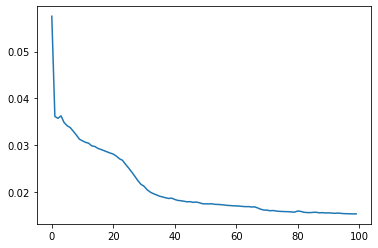

In [ ]:
plt.plot(history)

In [ ]:
# Testing the AE
test_loss = 0

for user in testset.userid.unique():
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_tensor_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().to(device).unsqueeze(0)
    target = user_tensor_test.clone()
    
    output = ae(user_tensor_test)
    target.require_grad = False

    loss = criterion(output, target)
    test_loss += loss.data.item()
    
print('test loss: '+str(test_loss / testset.userid.nunique()))

test loss: 0.02183415055544881


In [ ]:
scores = torch.zeros((len(testset.userid.unique()), data_description['n_items']))
for i, user in enumerate(testset.userid.unique()):
    itemidx = testset.loc[testset.userid == user, data_description['items']].values
    feedbackidx = testset.loc[testset.userid == user, data_description['feedback']].values
    values = np.ones(len(itemidx), dtype=np.float32)

    user_matrix_test = torch.sparse_coo_tensor(np.array([itemidx, feedbackidx-1]), torch.tensor(values),
                              size=torch.Size((data_description["n_items"], data_description['n_ratings']))).to_dense().unsqueeze(0).to(device)
    
    output = ae(user_matrix_test)
    scores[i] = output[0][:, -1].T

        
scores = scores.detach().numpy()

In [ ]:
# our
downvote_seen_items(scores, testset, data_description)
make_prediction(scores, holdout, data_description)

HR@5 = 0.0207, MRR@5 = 0.0097, Coverage@5 = 0.2287
HR_pos@5 = 0.0196, HR_neg@5 = 0.0012
MRR_pos@5 = 0.0089, MRR_neg@5 = 0.0007
Matthews@5 = 0.0455
-------------------------------------
HR@10 = 0.0288, MRR@10 = 0.0107, Coverage@10 = 0.2981
HR_pos@10 = 0.0265, HR_neg@10 = 0.0023
MRR_pos@10 = 0.0098, MRR_neg@10 = 0.0009
Matthews@10 = 0.0427
-------------------------------------
HR@20 = 0.0454, MRR@20 = 0.0119, Coverage@20 = 0.4004
HR_pos@20 = 0.0431, HR_neg@20 = 0.0023
MRR_pos@20 = 0.0110, MRR_neg@20 = 0.0009
Matthews@20 = 0.0711
-------------------------------------


(0.010699453252644743, 0.02875215641173088, 0.042746208372664046)